<a href="https://colab.research.google.com/github/huyle3/competition_data/blob/main/PredictingWinVer2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install catboost

In [2]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.utils import resample

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.naive_bayes import GaussianNB


In [3]:
#reading csv in
data_dict_url = "https://raw.githubusercontent.com/huyle3/competition_data/refs/heads/main/DataDictionary.csv"
data_dict_csv = pd.read_csv(data_dict_url)
east_regional_games_url = "https://raw.githubusercontent.com/huyle3/competition_data/refs/heads/main/East%20Regional%20Games%20to%20predict.csv"
east_regional_games_csv = pd.read_csv(east_regional_games_url)
team_regional_groups_url = "https://raw.githubusercontent.com/huyle3/competition_data/refs/heads/main/Team%20Region%20Groups.csv"
team_regional_groups_csv = pd.read_csv(team_regional_groups_url)
df_url = 'https://raw.githubusercontent.com/huyle3/competition_data/refs/heads/main/games_2022.csv'
df = pd.read_csv(df_url)

In [4]:
df['fg%'] = ((df['FGM_2'] + df['FGM_3']) / (df['FGA_2'] + df['FGA_3'])) * 100

In [5]:
print(df.shape)

(10438, 31)


In [6]:
df.head()

,game_id,game_date,team,FGA_2,FGM_2,FGA_3,FGM_3,FTA,FTM,AST,...,notD1_incomplete,OT_length_min_tot,rest_days,attendance,tz_dif_H_E,prev_game_dist,home_away,home_away_NS,travel_dist,fg%
0,game_2022_2011,2021-12-30,georgia_lady_bulldogs,50,22,11,5,6,3,14,...,False,NaN,9.0,3241.0,0.0,0.0,home,1,0.0,44.262295
1,game_2022_2011,2021-12-30,lsu_tigers,50,24,11,4,15,8,15,...,False,NaN,3.0,3241.0,0.0,824.0,away,-1,824.0,45.901639
2,game_2022_2012,2021-12-30,missouri_tigers,43,18,15,7,16,13,10,...,False,5.0,8.0,6139.0,0.0,371.0,home,1,0.0,43.103448
3,game_2022_2012,2021-12-30,south_carolina_gamecocks,55,23,21,6,9,5,15,...,False,5.0,9.0,6139.0,0.0,1154.0,away,-1,1154.0,38.157895
4,game_2022_2013,2021-12-30,tennessee_lady_volunteers,41,20,15,4,15,10,16,...,False,NaN,3.0,8124.0,0.0,0.0,home,1,0.0,42.857143


Ranking Teams

Feature Creation

In [7]:
#2 pointer field goal percentage
df['fg_2%'] = (df['FGM_2'] / df['FGA_2']) * 100
# 3 pointer field goal percentage
df['fg_3%'] = (df['FGM_3'] /df['FGA_3']) * 100

In [8]:
df['fg_2%'].head()
df['fg_3%'].head()

,fg_3%
0,45.454545
1,36.363636
2,46.666667
3,28.571429
4,26.666667


In [9]:
df['AST_TO'] = df['AST'] / df['TOV']

In [10]:
# Compute each team's contribution to PIE
df["team_contribution"] = (
    df["team_score"] + df["FGM_2"] + df["FGM_3"] + df["FTM"]
    - df["FGA_2"] - df["FGA_3"] - df["FTA"] + df["DREB"]
    + (df["OREB"] / 2) + df["AST"] + df["STL"] + df["BLK"]
    - df["F_personal"] - df["TOV"]
)

# Merge with itself to get opponent contributions based on game_id
df = df.merge(df[["game_id", "team", "team_contribution"]],
              on="game_id",
              suffixes=("", "_opp"))

# Remove same-team matches (keep only opponent rows)
df = df[df["team"] != df["team_opp"]]

# Compute total game impact
df["game_total"] = df["team_contribution"] + df["team_contribution_opp"]

# Calculate PIE
df["PIE"] = df["team_contribution"] / df["game_total"]

# Drop extra columns
df = df.drop(columns=["team_opp", "team_contribution_opp"])

In [11]:
#Turnover ratio
df['TO%'] = (df['TOV'] * 100)/ ((df['FGA_2'] + df['FGA_3']) + (df['FTA'] * 0.44) + df['AST'] + df['TOV'])

In [12]:
#Effective field goal percentage
df['EFG%'] = (df['FGM_2'] + df['FGM_3'] + (1.5 * df['FGM_3'])) / (df['FGA_2'] + df['FGA_3'])

Create Target Var

In [13]:
#if team score is greater than opponent team score than they won
df['win'] = df.apply(lambda row: 1 if row['team_score'] > row['opponent_team_score'] else 0, axis=1)
df['win'].head()

,win
1,0
2,1
5,1
6,0
9,1


In [14]:
print(df.columns)

Index(['game_id', 'game_date', 'team', 'FGA_2', 'FGM_2', 'FGA_3', 'FGM_3',
       'FTA', 'FTM', 'AST', 'BLK', 'STL', 'TOV', 'TOV_team', 'DREB', 'OREB',
       'F_tech', 'F_personal', 'team_score', 'opponent_team_score',
       'largest_lead', 'notD1_incomplete', 'OT_length_min_tot', 'rest_days',
       'attendance', 'tz_dif_H_E', 'prev_game_dist', 'home_away',
       'home_away_NS', 'travel_dist', 'fg%', 'fg_2%', 'fg_3%', 'AST_TO',
       'team_contribution', 'game_total', 'PIE', 'TO%', 'EFG%', 'win'],
      dtype='object')


In [15]:
# import pandas as pd
# import numpy as np

# # Elo parameters
# K = 32
# initial_elo = 1500
# rest_penalty = 5  # Rest penalty per fewer rest days

# # Initialize Elo ratings for each team
# elo_ratings = {team: initial_elo for team in df["team"].unique()}

# def expected_win(elo1, elo2):
#     """Calculate the probability of team1 winning."""
#     return 1 / (1 + 10 ** ((elo2 - elo1) / 400))

# def strength_of_schedule(team, past_games):
#     """Calculate strength of schedule based on opponent Elo ratings."""
#     opponents = past_games[past_games["team"] == team]["opponent_team_score"].index
#     opponent_elos = [elo_ratings.get(past_games.loc[idx, "team"], initial_elo) for idx in opponents]
#     return np.mean(opponent_elos) if opponent_elos else initial_elo

# def dynamic_K(elo_A, elo_B):
#     """Adjust K-factor based on Elo rating difference."""
#     base_K = 32
#     elo_diff = abs(elo_A - elo_B)
#     if elo_diff > 200:
#         return base_K * 1.5
#     elif elo_diff > 100:
#         return base_K * 1.2
#     return base_K

# def update_elo(game_data):
#     """Updates the Elo ratings based on a single game result."""
#     team_A, team_B = game_data["team"].values
#     score_A, score_B = game_data["team_score"].values
#     rest_A, rest_B = game_data["rest_days"].fillna(3).values
#     attendance = game_data["attendance"].values[0]

#     # Pre-game Elo ratings
#     pre_elo_A, pre_elo_B = elo_ratings[team_A], elo_ratings[team_B]

#     # Strength of Schedule (SOS)
#     sos_A = strength_of_schedule(team_A, df)
#     sos_B = strength_of_schedule(team_B, df)
#     sos_factor = (sos_A / sos_B) if sos_B != 0 else 1

#     # Home-Court Advantage (HCA)
#     hca_bonus = min(50, attendance / 100)  # Scaled home-court advantage
#     elo_A = pre_elo_A + (hca_bonus if attendance > 0 else 0)
#     elo_B = pre_elo_B

#     # Score Margin Factor
#     score_diff_factor = np.log(abs(score_A - score_B) + 1)

#     # Expected Win Probability
#     exp_A = expected_win(elo_A, elo_B)
#     result_A = 1 if score_A > score_B else 0

#     # Rest Adjustment
#     rest_factor_A = max(0.75, 1 - (rest_B - rest_A) * rest_penalty / 100)
#     rest_factor_B = max(0.75, 1 - (rest_A - rest_B) * rest_penalty / 100)

#     # Dynamic K-value
#     dynamic_K_value = dynamic_K(elo_A, elo_B)

#     # Elo Updates
#     new_elo_A = pre_elo_A + dynamic_K_value * (result_A - exp_A) * score_diff_factor * rest_factor_A * sos_factor
#     new_elo_B = pre_elo_B + dynamic_K_value * ((1 - result_A) - (1 - exp_A)) * score_diff_factor * rest_factor_B * (1 / sos_factor)

#     # Update Elo Ratings
#     elo_ratings[team_A] = new_elo_A
#     elo_ratings[team_B] = new_elo_B

#     return pre_elo_A, pre_elo_B  # Return pre-game Elo ratings
# # Ensure sorting before Elo computation
# df = df.sort_values(['game_date', 'game_id']).reset_index(drop=True)
# # Add Elo ratings to dataframe
# elo_history = []
# games = df.groupby("game_id")

# for _, game_data in games:
#     pre_elo_A, pre_elo_B = update_elo(game_data)  # Get Elo before updating
#     game_data = game_data.copy()  # Avoid modifying original DataFrame

#     # Assign Elo ratings before the game
#     game_data["team_elo_before"] = game_data["team"].map(lambda x: pre_elo_A if x == game_data["team"].values[0] else pre_elo_B)
#     elo_history.append(game_data)

# # Concatenate results
# df_with_elo = pd.concat(elo_history).reset_index(drop=True)


In [16]:
import pandas as pd
import numpy as np

# Elo parameters
K = 32
initial_elo = 1500
rest_penalty = 5  # Rest penalty per fewer rest days

# Initialize Elo ratings for each team
elo_ratings = {team: initial_elo for team in df["team"].unique()}

def expected_win(elo1, elo2):
    """Calculate the probability of team1 winning."""
    return 1 / (1 + 10 ** ((elo2 - elo1) / 400))

def strength_of_schedule(team, past_games):
    """Calculate strength of schedule based on opponent Elo ratings."""
    opponents = past_games[past_games["team"] == team]["opponent_team_score"].index
    opponent_elos = [elo_ratings.get(past_games.loc[idx, "team"], initial_elo) for idx in opponents]
    return np.mean(opponent_elos) if opponent_elos else initial_elo

def dynamic_K(elo_A, elo_B):
    """Adjust K-factor based on Elo rating difference."""
    base_K = 32
    elo_diff = abs(elo_A - elo_B)
    if elo_diff > 200:
        return base_K * 1.5
    elif elo_diff > 100:
        return base_K * 1.2
    return base_K

def update_elo(game_data):
    """Updates the Elo ratings based on a single game result."""
    team_A, team_B = game_data["team"].values
    score_A, score_B = game_data["team_score"].values
    rest_A, rest_B = game_data["rest_days"].fillna(3).values
    attendance = game_data["attendance"].values[0]

    # Pre-game Elo ratings
    pre_elo_A, pre_elo_B = elo_ratings[team_A], elo_ratings[team_B]

    # Strength of Schedule (SOS)
    sos_A = strength_of_schedule(team_A, df)
    sos_B = strength_of_schedule(team_B, df)
    sos_factor = (sos_A / sos_B) if sos_B != 0 else 1

    # Home-Court Advantage (HCA)
    hca_bonus = min(50, attendance / 100)  # Scaled home-court advantage
    elo_A = pre_elo_A + (hca_bonus if attendance > 0 else 0)
    elo_B = pre_elo_B

    # Score Margin Factor
    score_diff_factor = np.log(abs(score_A - score_B) + 1)

    # Expected Win Probability
    exp_A = expected_win(elo_A, elo_B)
    result_A = 1 if score_A > score_B else 0

    # Rest Adjustment
    rest_factor_A = max(0.75, 1 - (rest_B - rest_A) * rest_penalty / 100)
    rest_factor_B = max(0.75, 1 - (rest_A - rest_B) * rest_penalty / 100)

    # Dynamic K-value
    dynamic_K_value = dynamic_K(elo_A, elo_B)

    # Elo Updates
    new_elo_A = pre_elo_A + dynamic_K_value * (result_A - exp_A) * score_diff_factor * rest_factor_A * sos_factor
    new_elo_B = pre_elo_B + dynamic_K_value * ((1 - result_A) - (1 - exp_A)) * score_diff_factor * rest_factor_B * (1 / sos_factor)

    # Update Elo Ratings
    elo_ratings[team_A] = new_elo_A
    elo_ratings[team_B] = new_elo_B

    return pre_elo_A, pre_elo_B  # Return pre-game Elo ratings

# Ensure sorting before Elo computation
df = df.sort_values(['game_date', 'game_id']).reset_index(drop=True)

# Compute Elo ratings for each game
elo_history = []
games = df.groupby("game_id")

for _, game_data in games:
    pre_elo_A, pre_elo_B = update_elo(game_data)  # Get Elo before updating
    game_data = game_data.copy()  # Avoid modifying original DataFrame

    # Assign Elo ratings before the game
    game_data["team_elo_before"] = game_data["team"].map(lambda x: pre_elo_A if x == game_data["team"].values[0] else pre_elo_B)
    elo_history.append(game_data)

# Concatenate results
df_with_elo = pd.concat(elo_history).reset_index(drop=True)

# Ensure `team_elo_before` exists
if "team_elo_before" not in df_with_elo.columns:
    raise KeyError("team_elo_before is missing from df_with_elo!")

# Ensure each team’s games are sorted correctly before computing rolling stats
df_with_elo = df_with_elo.sort_values(['team', 'game_date']).reset_index(drop=True)

# Compute past statistics
def compute_past_stats(df):
    df['total_games_before'] = df.groupby('team').cumcount()  # Games before current one
    df['total_wins_before'] = df.groupby('team')['win'].cumsum().shift(1).fillna(0)  # Wins before
    df['win_pct_before'] = df['total_wins_before'] / df['total_games_before'].replace(0, 1)  # Avoid divide by zero
    df['total_points_before'] = df.groupby('team')['team_score'].cumsum().shift(1).fillna(0)  # Points before
    df['avg_ppg_before'] = df['total_points_before'] / df['total_games_before'].replace(0, 1)

    df['last5_wins'] = df.groupby('team')['win'].rolling(window=5, min_periods=1).sum().shift(1).reset_index(level=0, drop=True)

    # Compute rolling averages for all numeric columns except identifiers
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    exclude_cols = ['game_id','team', 'game_date', 'win', 'team_score', 'opponent_team', 'total_games_before', 'total_wins_before', 'win_pct_before', 'total_points_before', 'avg_ppg_before', 'last5_wins', 'team_elo_before']

    for col in numeric_cols:
        if col not in exclude_cols:
            df[f'avg_{col}_before'] = df.groupby('team')[col].expanding().mean().shift(1).reset_index(level=0, drop=True)

    return df

# Apply rolling statistics function
df_new = compute_past_stats(df_with_elo)

# Ensure `team_elo_before` is correctly retained after rolling statistics computation
df_new['team_elo_before'] = df_with_elo['team_elo_before']

# Final sorting before merging teams
df_new = df_new.sort_values(['game_date', 'game_id', 'team']).reset_index(drop=True)

# Final DataFrame with Elo ratings and past stats
df_new.head()


,game_id,game_date,team,FGA_2,FGM_2,FGA_3,FGM_3,FTA,FTM,AST,...,avg_travel_dist_before,avg_fg%_before,avg_fg_2%_before,avg_fg_3%_before,avg_AST_TO_before,avg_team_contribution_before,avg_game_total_before,avg_PIE_before,avg_TO%_before,avg_EFG%_before
0,game_2022_1,2021-11-09,texas_am_aggies,39,18,24,12,28,15,23,...,NaN,28.750448,36.111111,18.506494,0.376518,4.750000,106.750000,0.041299,20.085753,0.403509
1,game_2022_1,2021-11-09,texas_am_corpus_christi_islanders,57,21,13,0,22,12,12,...,693.000000,41.155901,42.988929,36.617544,1.026012,51.568966,99.327586,0.533661,15.476259,0.566753
2,game_2022_10,2021-11-09,james_madison_dukes,51,24,14,5,29,21,3,...,267.666667,39.557661,45.084704,29.228995,1.004453,47.603448,83.310345,0.581096,12.997492,0.545819
3,game_2022_10,2021-11-09,virginia_cavaliers,48,25,15,1,28,16,15,...,275.666667,40.520426,46.968104,30.443077,1.429185,56.600000,99.933333,0.570734,13.845411,0.591466
4,game_2022_100,2021-11-09,charlotte_49ers,55,21,15,3,15,12,13,...,213.857143,35.813353,40.415407,26.491704,0.517039,21.017857,88.857143,0.228403,23.908963,0.500646


In [17]:
df_new.head()

,game_id,game_date,team,FGA_2,FGM_2,FGA_3,FGM_3,FTA,FTM,AST,...,avg_travel_dist_before,avg_fg%_before,avg_fg_2%_before,avg_fg_3%_before,avg_AST_TO_before,avg_team_contribution_before,avg_game_total_before,avg_PIE_before,avg_TO%_before,avg_EFG%_before
0,game_2022_1,2021-11-09,texas_am_aggies,39,18,24,12,28,15,23,...,NaN,28.750448,36.111111,18.506494,0.376518,4.750000,106.750000,0.041299,20.085753,0.403509
1,game_2022_1,2021-11-09,texas_am_corpus_christi_islanders,57,21,13,0,22,12,12,...,693.000000,41.155901,42.988929,36.617544,1.026012,51.568966,99.327586,0.533661,15.476259,0.566753
2,game_2022_10,2021-11-09,james_madison_dukes,51,24,14,5,29,21,3,...,267.666667,39.557661,45.084704,29.228995,1.004453,47.603448,83.310345,0.581096,12.997492,0.545819
3,game_2022_10,2021-11-09,virginia_cavaliers,48,25,15,1,28,16,15,...,275.666667,40.520426,46.968104,30.443077,1.429185,56.600000,99.933333,0.570734,13.845411,0.591466
4,game_2022_100,2021-11-09,charlotte_49ers,55,21,15,3,15,12,13,...,213.857143,35.813353,40.415407,26.491704,0.517039,21.017857,88.857143,0.228403,23.908963,0.500646


In [18]:

# df_with_elo = df.sort_values(['team', 'game_date'])

# # Function to compute rolling statistics before each game
# def compute_past_stats(df):
#     df['total_games_before'] = df.groupby('team').cumcount()  # Games before current one
#     df['total_wins_before'] = df.groupby('team')['win'].cumsum().shift(1).fillna(0)  # Wins before
#     df['win_pct_before'] = df['total_wins_before'] / df['total_games_before'].replace(0, 1)  # Avoid divide by zero
#     df['total_points_before'] = df.groupby('team')['team_score'].cumsum().shift(1).fillna(0)  # Points before
#     df['avg_ppg_before'] = df['total_points_before'] / df['total_games_before'].replace(0, 1)


#     df['last5_wins'] = df.groupby('team')['win'].rolling(window=5, min_periods=1).sum().shift(1).reset_index(level=0, drop=True)

#      # Compute rolling averages for all numeric columns except identifiers
#     numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
#     exclude_cols = ['team_elo_before','game_id','team', 'date', 'win', 'team_score', 'opponent_team', 'total_games_before', 'total_wins_before', 'win_pct_before', 'total_points_before', 'avg_ppg_before', 'last5_wins']

#     for col in numeric_cols:
#       if col not in exclude_cols:
#           df[f'avg_{col}_before'] = df.groupby('team')[col].expanding().mean().shift(1).reset_index(level=0, drop=True)


#     return df

# # Apply function
# df_new = compute_past_stats(df_with_elo)

# # Reassign `team_elo_before` to prevent any accidental overwrites
# df_new['team_elo_before'] = df_with_elo['team_elo_before']

In [19]:
print(df_new.columns)

Index(['game_id', 'game_date', 'team', 'FGA_2', 'FGM_2', 'FGA_3', 'FGM_3',
       'FTA', 'FTM', 'AST', 'BLK', 'STL', 'TOV', 'TOV_team', 'DREB', 'OREB',
       'F_tech', 'F_personal', 'team_score', 'opponent_team_score',
       'largest_lead', 'notD1_incomplete', 'OT_length_min_tot', 'rest_days',
       'attendance', 'tz_dif_H_E', 'prev_game_dist', 'home_away',
       'home_away_NS', 'travel_dist', 'fg%', 'fg_2%', 'fg_3%', 'AST_TO',
       'team_contribution', 'game_total', 'PIE', 'TO%', 'EFG%', 'win',
       'team_elo_before', 'total_games_before', 'total_wins_before',
       'win_pct_before', 'total_points_before', 'avg_ppg_before', 'last5_wins',
       'avg_FGA_2_before', 'avg_FGM_2_before', 'avg_FGA_3_before',
       'avg_FGM_3_before', 'avg_FTA_before', 'avg_FTM_before',
       'avg_AST_before', 'avg_BLK_before', 'avg_STL_before', 'avg_TOV_before',
       'avg_TOV_team_before', 'avg_DREB_before', 'avg_OREB_before',
       'avg_F_tech_before', 'avg_F_personal_before',
       'avg_op

In [20]:
columns_drop = ['FGA_2', 'FGM_2', 'FGA_3', 'FGM_3',
       'FTA', 'FTM', 'AST', 'BLK', 'STL', 'TOV', 'TOV_team', 'DREB', 'OREB',
       'F_tech', 'F_personal', 'team_score', 'opponent_team_score',
       'largest_lead', 'notD1_incomplete', 'OT_length_min_tot', 'rest_days',
       'attendance', 'tz_dif_H_E', 'prev_game_dist', 'home_away',
       'home_away_NS', 'travel_dist', 'fg%', 'fg_2%', 'fg_3%', 'AST_TO',
       'team_contribution', 'game_total', 'PIE', 'TO%', 'EFG%']
df_new.drop(columns=columns_drop, inplace=True)

In [21]:
# Drop the first game for each team
df_new = df_new.groupby('team').apply(lambda group: group.iloc[1:]).reset_index(drop=True)

In [22]:
print(df_new.isnull().sum())

game_id                              0
game_date                            0
team                                 0
win                                  0
team_elo_before                      0
total_games_before                   0
total_wins_before                    0
win_pct_before                       0
total_points_before                  0
avg_ppg_before                       0
last5_wins                           0
avg_FGA_2_before                     0
avg_FGM_2_before                     0
avg_FGA_3_before                     0
avg_FGM_3_before                     0
avg_FTA_before                       0
avg_FTM_before                       0
avg_AST_before                       0
avg_BLK_before                       0
avg_STL_before                       0
avg_TOV_before                       0
avg_TOV_team_before                  0
avg_DREB_before                      0
avg_OREB_before                      0
avg_F_tech_before                    0
avg_F_personal_before    

In [23]:
print(df_new.columns)

Index(['game_id', 'game_date', 'team', 'win', 'team_elo_before',
       'total_games_before', 'total_wins_before', 'win_pct_before',
       'total_points_before', 'avg_ppg_before', 'last5_wins',
       'avg_FGA_2_before', 'avg_FGM_2_before', 'avg_FGA_3_before',
       'avg_FGM_3_before', 'avg_FTA_before', 'avg_FTM_before',
       'avg_AST_before', 'avg_BLK_before', 'avg_STL_before', 'avg_TOV_before',
       'avg_TOV_team_before', 'avg_DREB_before', 'avg_OREB_before',
       'avg_F_tech_before', 'avg_F_personal_before',
       'avg_opponent_team_score_before', 'avg_largest_lead_before',
       'avg_OT_length_min_tot_before', 'avg_rest_days_before',
       'avg_attendance_before', 'avg_tz_dif_H_E_before',
       'avg_prev_game_dist_before', 'avg_home_away_NS_before',
       'avg_travel_dist_before', 'avg_fg%_before', 'avg_fg_2%_before',
       'avg_fg_3%_before', 'avg_AST_TO_before', 'avg_team_contribution_before',
       'avg_game_total_before', 'avg_PIE_before', 'avg_TO%_before',
     

In [24]:
selected_features = [
    'game_id', 'team', 'game_date', 'win', 'win_pct_before', 'last5_wins', 'avg_AST_before',
    'avg_BLK_before', 'avg_STL_before', 'avg_TOV_before', 'avg_DREB_before', 'avg_OREB_before',
    'avg_largest_lead_before', 'avg_AST_TO_before', 'avg_PIE_before', 'avg_TO%_before',
    'avg_EFG%_before', 'avg_OT_length_min_tot_before', 'avg_fg%_before' , 'avg_fg_2%_before',
    'avg_fg_3%_before', 'avg_game_total_before', 'team_elo_before'
]
df_selected = df_new[selected_features]

In [25]:
# Sort by game_id to ensure consistent order
df_selected = df_selected.sort_values(by=["game_id", "team"])

# Create two separate DataFrames for each team in the game
df_team1 = df_selected.groupby("game_id").nth(0).reset_index()
df_team2 = df_selected.groupby("game_id").nth(1).reset_index()

# Rename columns to differentiate team1 and team2
df_team1 = df_team1.add_prefix("team1_")
df_team2 = df_team2.add_prefix("team2_")

# Fix column names (game_id shouldn't be prefixed)
df_team1.rename(columns={"team1_game_id": "game_id"}, inplace=True)
df_team2.rename(columns={"team2_game_id": "game_id"}, inplace=True)

# Merge team1 and team2 stats on game_id
df_merged = pd.merge(df_team1, df_team2, on="game_id")

# Create target variable: 1 if team1 won, 0 if team2 won
df_merged["team1_win"] = (df_merged["team1_win"] == 1).astype(int)

# List of features to compute differences for
features_to_diff = ["win_pct_before", "last5_wins", "avg_AST_before", "avg_BLK_before", "avg_STL_before",
    "avg_TOV_before", "avg_DREB_before", "avg_OREB_before", "avg_largest_lead_before",
    "avg_AST_TO_before", "avg_PIE_before", "avg_TO%_before", "avg_EFG%_before",
    "avg_OT_length_min_tot_before", "avg_fg%_before", "avg_fg_2%_before", "avg_fg_3%_before",
    "avg_game_total_before", "team_elo_before"]  # Modify as needed

# Create difference features
for feature in features_to_diff:
    df_merged[f"{feature}_diff"] = df_merged[f"team1_{feature}"] - df_merged[f"team2_{feature}"]

# Drop original team1 and team2 columns (except necessary ones like game_id, team1_win)
columns_to_drop = [f"team1_{feature}" for feature in features_to_diff] + [f"team2_{feature}" for feature in features_to_diff]
df_merged.drop(columns=columns_to_drop + ["team1_game_date", "team2_game_date"], inplace=True)


In [26]:
print(df_merged.shape)

(4841, 26)


In [27]:
df_merged.head()

,team1_index,game_id,team1_team,team1_win,team2_index,team2_team,team2_win,win_pct_before_diff,last5_wins_diff,avg_AST_before_diff,...,avg_AST_TO_before_diff,avg_PIE_before_diff,avg_TO%_before_diff,avg_EFG%_before_diff,avg_OT_length_min_tot_before_diff,avg_fg%_before_diff,avg_fg_2%_before_diff,avg_fg_3%_before_diff,avg_game_total_before_diff,team_elo_before_diff
0,829,game_2022_1000,bucknell_bison,1,5483,north_dakota_fighting_hawks,0,0.250000,1.0,-1.250000,...,0.220480,0.144133,-2.099440,-0.036538,NaN,-1.782334,-4.922565,2.505981,-22.125000,0.0
1,1651,game_2022_1001,creighton_bluejays,1,5709,northern_iowa_panthers,0,-0.250000,-1.0,5.250000,...,0.410854,-0.009341,-0.968010,-0.023840,NaN,-2.466796,-2.811061,-1.175371,8.750000,0.0
2,7941,game_2022_1002,temple_owls,1,9239,villanova_wildcats,0,0.066667,1.0,-2.666667,...,-0.076690,-0.053258,-2.825869,-0.099331,NaN,-0.754932,2.890511,-9.869049,0.933333,0.0
3,2093,game_2022_1003,eastern_kentucky_colonels,0,9795,xavier_musketeers,1,0.100000,0.0,0.900000,...,0.326428,0.061871,-2.303814,0.012072,NaN,-1.829924,-0.880360,1.231410,-14.400000,0.0
4,3208,game_2022_1004,illinois_fighting_illini,0,4662,middle_tennessee_blue_raiders,1,-0.200000,-1.0,1.800000,...,-0.101424,-0.114702,0.871915,-0.038124,NaN,4.619344,3.231425,3.406396,31.000000,0.0


In [28]:
print(df_merged.isnull().sum())

team1_index                             0
game_id                                 0
team1_team                              0
team1_win                               0
team2_index                             0
team2_team                              0
team2_win                               0
win_pct_before_diff                     0
last5_wins_diff                         0
avg_AST_before_diff                     0
avg_BLK_before_diff                     0
avg_STL_before_diff                     0
avg_TOV_before_diff                     0
avg_DREB_before_diff                    0
avg_OREB_before_diff                    0
avg_largest_lead_before_diff            0
avg_AST_TO_before_diff                  0
avg_PIE_before_diff                     0
avg_TO%_before_diff                     0
avg_EFG%_before_diff                    0
avg_OT_length_min_tot_before_diff    3782
avg_fg%_before_diff                     0
avg_fg_2%_before_diff                   0
avg_fg_3%_before_diff             

In [29]:
print(df_merged.dtypes)

team1_index                            int64
game_id                               object
team1_team                            object
team1_win                              int64
team2_index                            int64
team2_team                            object
team2_win                              int64
win_pct_before_diff                  float64
last5_wins_diff                      float64
avg_AST_before_diff                  float64
avg_BLK_before_diff                  float64
avg_STL_before_diff                  float64
avg_TOV_before_diff                  float64
avg_DREB_before_diff                 float64
avg_OREB_before_diff                 float64
avg_largest_lead_before_diff         float64
avg_AST_TO_before_diff               float64
avg_PIE_before_diff                  float64
avg_TO%_before_diff                  float64
avg_EFG%_before_diff                 float64
avg_OT_length_min_tot_before_diff    float64
avg_fg%_before_diff                  float64
avg_fg_2%_

In [30]:

df_merged.drop(4764, inplace=True)
# One game was corrupt for some reason, just deleted it

Data preprocessing

In [31]:
print(df_merged.dtypes)

team1_index                            int64
game_id                               object
team1_team                            object
team1_win                              int64
team2_index                            int64
team2_team                            object
team2_win                              int64
win_pct_before_diff                  float64
last5_wins_diff                      float64
avg_AST_before_diff                  float64
avg_BLK_before_diff                  float64
avg_STL_before_diff                  float64
avg_TOV_before_diff                  float64
avg_DREB_before_diff                 float64
avg_OREB_before_diff                 float64
avg_largest_lead_before_diff         float64
avg_AST_TO_before_diff               float64
avg_PIE_before_diff                  float64
avg_TO%_before_diff                  float64
avg_EFG%_before_diff                 float64
avg_OT_length_min_tot_before_diff    float64
avg_fg%_before_diff                  float64
avg_fg_2%_

In [32]:
print(df_merged.isnull().sum())

team1_index                             0
game_id                                 0
team1_team                              0
team1_win                               0
team2_index                             0
team2_team                              0
team2_win                               0
win_pct_before_diff                     0
last5_wins_diff                         0
avg_AST_before_diff                     0
avg_BLK_before_diff                     0
avg_STL_before_diff                     0
avg_TOV_before_diff                     0
avg_DREB_before_diff                    0
avg_OREB_before_diff                    0
avg_largest_lead_before_diff            0
avg_AST_TO_before_diff                  0
avg_PIE_before_diff                     0
avg_TO%_before_diff                     0
avg_EFG%_before_diff                    0
avg_OT_length_min_tot_before_diff    3781
avg_fg%_before_diff                     0
avg_fg_2%_before_diff                   0
avg_fg_3%_before_diff             

In [33]:
#drop unneeded columns
column_drop = ['team2_win', 'team2_index', 'team2_team', 'team1_team', 'game_id', 'team1_index', 'avg_OT_length_min_tot_before_diff']
df_merged.drop(columns=column_drop, inplace=True)

In [34]:
X = df_merged.drop(columns='team1_win')
y = df_merged['team1_win']

In [35]:
X = df_merged.drop(columns='team1_win')
y = df_merged['team1_win']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.16, random_state=1)

Normalization

In [53]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.fit_transform(X_valid)

Log loss on

In [37]:
# # Standard Libraries
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import log_loss

# # Model Selection & Evaluation
# from sklearn.model_selection import StratifiedKFold, cross_val_score

# # Machine Learning Models
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# losses= {}
# models = {
#     "Logistic Regression": LogisticRegression(),
#     "Random Forest": RandomForestClassifier(n_estimators=100),
#     "Gradient Boosting": GradientBoostingClassifier(),
#     "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
#     "LightGBM": LGBMClassifier(),
#     "CatBoost": CatBoostClassifier(verbose=0),
#     "SVM": SVC()
# }
# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# param_grid = {
#     'n_estimators': [100, 200],
#     'learning_rate': [0.01, 0.1],
#     'max_depth': [3, 6, 10],
#     'subsample': [0.8, 1.0],
# }




# for name, model in models.items():
#   print(f"Training {name}...")

#   log_loss_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_log_loss')

#   losses[name] = -log_loss_scores
#   print(f"Mean Log-Loss for {name}: {np.mean(losses[name]):.4f}")
# for name, loss in losses.items():
#   plt.plot(range(1, len(loss)+1), loss, label=name)
# # Add labels and title
# plt.xlabel('Fold')
# plt.ylabel('Log-Loss (Cross-Entropy Loss)')
# plt.title('Model Log-Loss (Cross-Entropy Loss) Across Cross-Validation Folds')
# plt.legend(title='Models')

# # Show the plot
# plt.show()

In [38]:
# Standard Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV

# Model Selection & Evaluation
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),
    "SVM": SVC()
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6, 10],
    'subsample': [0.8, 1.0],
}


for name, model in models.items():
  print(f"Training {name}...")

  scores = cross_val_score(model, X_train_scaled, y, cv=cv, scoring='accuracy')

  results[name] = np.mean(scores)

results_df = pd.DataFrame(results.items(), columns=['Model', 'Accuracy']).sort_values(by='Accuracy', ascending=False)
print("\nModel Performance with Stratified CV:")
print(results_df)

Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Number of positive: 1971, number of negative: 1901
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4346
[LightGBM] [Info] Number of data points in the train set: 3872, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509039 -> initscore=0.036161
[LightGBM] [Info] Start training from score 0.036161
[LightGBM] [Info] Number of positive: 1971, number of negative: 1901
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4346
[LightGBM] [Info] Number of data points in the train set: 3872, number of used features: 18
[LightGBM] [Info] [binary

In [39]:
print(X.shape)

(4840, 18)


In [40]:
# Check if GPU is available and set TensorFlow to use it
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Prevents memory overflow issues
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')  # Use the first available GPU
        print("GPU is being used")
    except RuntimeError as e:
        print(e)

Epoch 1/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5061 - loss: 0.7303 - val_accuracy: 0.5342 - val_loss: 0.6891
Epoch 2/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6129 - loss: 0.6785 - val_accuracy: 0.6206 - val_loss: 0.6567
Epoch 3/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6720 - loss: 0.6443 - val_accuracy: 0.6839 - val_loss: 0.6161
Epoch 4/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6734 - loss: 0.6158 - val_accuracy: 0.6413 - val_loss: 0.6453
Epoch 5/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7006 - loss: 0.5866 - val_accuracy: 0.6723 - val_loss: 0.6219
Epoch 6/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6955 - loss: 0.5827 - val_accuracy: 0.6684 - val_loss: 0.6302
Epoch 7/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6966 - loss: 0.5738 - val_accuracy: 0.6839 - val_loss: 0.6050
Epoch 8/200
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7032 - loss: 0.5747 - val_accu

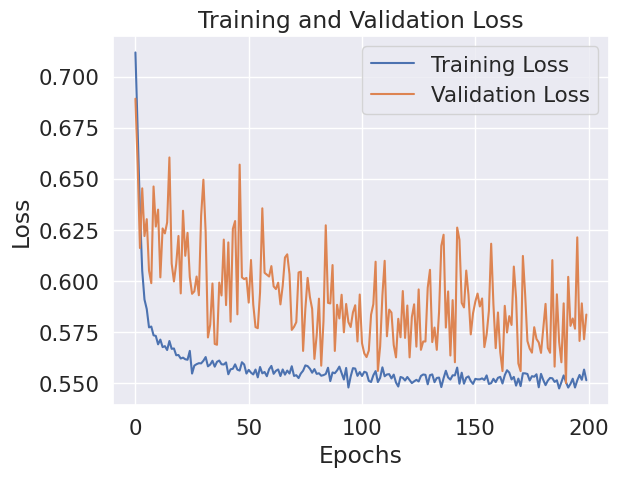

In [54]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

input_shape = (18,)
# Building a simple neural network model
model = models.Sequential([
    layers.Dense(16, input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.LeakyReLU(alpha=0.01),# Hidden layer with 128 neurons
    layers.Dense(8),
    layers.LeakyReLU(alpha=0.01),
    layers.Dropout(0.2),                    # Dropout for regularization
    layers.Dense(2, activation='sigmoid')  #
])

# Compile the model with loss function and optimizer
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with training and validation data
history = model.fit(X_train_scaled, y_train, epochs=200, validation_data=(X_valid_scaled, y_valid))

# Plotting Training and Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()